## <div align="center">PYTHON DATA PRODUCTS FOR PREDICTIVE ANALYSIS</div>
### <div align="center">COURSE PROJECT</div>
##### <div align="right">Luis Magalhaes<br>Oct 2020</div>

### <div align="center">COLLECTION AND PREPARATION OF DATA</div>

After importing libraries, we will load a JSON file obtained in Amazon.com with over 6 million reviews of the Electronics category. Then this data will be filtered, normalized, converted to their proper formats (dates and number, for example) and stored in a more convenient structure.

In [2]:
import json
import gzip
import datetime

from requests import get
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import itertools
from collections import Counter
from collections import defaultdict
import numpy as np
import pandas as pd
import string
import random

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.stem.porter import PorterStemmer
from sklearn import linear_model
from sklearn import svm
#from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

#from bs4 import BeautifulSoup

In [3]:
preliminary_data = []
f = open('Electronics_5.json')
iter = 0
for line in f:
    preliminary_data.append(json.loads(line))
    iter +=1
    if iter == 10000:
        break

In [4]:
dataset = list(filter(lambda i: i['verified'] == True, preliminary_data))

In [5]:
print('From a total of ' + str(len(preliminary_data)) + ' entries, ' + str(len(dataset)) + ' are verified.')

From a total of 10000 entries, 8570 are verified.


In [6]:
def fix_key(d, k):
    try:
        d[k] = int(d[k])
    except:
        d[k] = 0

def fix(d):
    fix_key(d, 'vote')
    fix_key(d, 'overall')
    return d

dataset = [fix(d) for d in dataset]

print('Here\'s an example of the entries in the file:')
dataset[2]

Here's an example of the entries in the file:


{'overall': 3,
 'vote': 8,
 'verified': True,
 'reviewTime': '02 4, 2000',
 'reviewerID': 'A3QHJ0FXK33OBE',
 'asin': '0151004714',
 'style': {'Format:': ' Hardcover'},
 'reviewerName': 'W. Shane Schmidt',
 'reviewText': 'I was taken in by reviews that compared this book with The Leopard or promised a bildungsroman set in a family that is isolated and on the move.  Well...I didn\'t feel any parallel with The Leopard and the author overstuffs her story with so many events that isolation is lost in the opportunity for  so many subplots.  And who\'s moving - in any sense - in this novel?  Where\'s the "bildung?"  The denouement?  The dsillusionner?  I must have  skimmed the wrong paragraph.\nI do agree that parts of the novel are very  engaging.  They are.  And, like some other readers, I did enjoy the events  in Algeria.  This is the strongest part of the novel, perhaps because it is  not so deeply stuck in the protagonist\'s life that had the unfortunate  knack of boring me in the first-

In [7]:
for i in dataset:
    i['rating'] = i.pop('overall', None)
    i['votes'] = i.pop('vote', None)
    i.pop('reviewerName', None)
    i.pop('style', None)
    t = datetime.datetime.fromtimestamp(i['unixReviewTime'])
    i['year'] = t.strftime('%Y')
    i['month'] = t.strftime('%m')
    i['date'] = t.strftime('%d')
    i.pop('verified', None)
    i.pop('reviewTime', None)
    i.pop('unixReviewTime', None)

In [8]:
for i in dataset:
    if len(i.keys()) != 9:
        dataset.remove(i)
print('From the original {}, there are {} entries that are verified and complete (no empty fields), so they will be further used in this analysis. \n Here is a sample of it:'.format(len(preliminary_data), len(dataset)))
dataset[2]

From the original 10000, there are 8531 entries that are verified and complete (no empty fields), so they will be further used in this analysis. 
 Here is a sample of it:


{'reviewerID': 'A3QHJ0FXK33OBE',
 'asin': '0151004714',
 'reviewText': 'I was taken in by reviews that compared this book with The Leopard or promised a bildungsroman set in a family that is isolated and on the move.  Well...I didn\'t feel any parallel with The Leopard and the author overstuffs her story with so many events that isolation is lost in the opportunity for  so many subplots.  And who\'s moving - in any sense - in this novel?  Where\'s the "bildung?"  The denouement?  The dsillusionner?  I must have  skimmed the wrong paragraph.\nI do agree that parts of the novel are very  engaging.  They are.  And, like some other readers, I did enjoy the events  in Algeria.  This is the strongest part of the novel, perhaps because it is  not so deeply stuck in the protagonist\'s life that had the unfortunate  knack of boring me in the first-person!  (Yeah, that\'s what I mean.)  Overall, the novel is just a bit overdone.  I prefer a bildungsroman - if  that\'s what this should be - to sh

___
Our data was incomplete, missing important information, like price, name (for our better understanding) and category. Let's fix this.

#### RETRIEVING ADDITIONAL PRODUCT INFO (WEB SCRAPING)

In [9]:
fields = defaultdict(list)

for d in dataset:
    for k, v in d.items():
        fields[k].append(v)

temp = fields
temp.pop('votes', None)
temp.pop('summary', None)
temp.pop('date', None)
temp.pop('reviewText', None)

df = pd.DataFrame(temp)
df.head()

,reviewerID,asin,rating,year,month
0,AAP7PPBU72QFM,0151004714,5,1999,09
1,A2E168DTVGE6SV,0151004714,3,2013,10
2,A3QHJ0FXK33OBE,0151004714,3,2000,02
3,A3IYSOTP3HA77N,0380709473,4,2013,06
4,A11SXV34PZUQ5E,0380709473,5,2016,06


In [10]:
temp2 = fields
temp2.pop('votes', None)
temp2.pop('reviewText', None)
temp2.pop('summary', None)
temp2.pop('date', None)

df = pd.DataFrame(temp2)
df.head()

,reviewerID,asin,rating,year,month
0,AAP7PPBU72QFM,0151004714,5,1999,09
1,A2E168DTVGE6SV,0151004714,3,2013,10
2,A3QHJ0FXK33OBE,0151004714,3,2000,02
3,A3IYSOTP3HA77N,0380709473,4,2013,06
4,A11SXV34PZUQ5E,0380709473,5,2016,06


In [11]:
asin_set = set(df['asin'])
asin_set = list(asin_set)
asin_set.sort()

print('Total number of products: ' + str(len(df['asin'])))
print('Total number of unique products in asin_set: ' + str(len(asin_set)))
print('Total number of unique products in dataframe: ' + str(len(df['asin'].unique())))
print('Example of product identifier: ' + asin_set[0])

Total number of products: 8531
Total number of unique products in asin_set: 302
Total number of unique products in dataframe: 302
Example of product identifier: 0101635370


In [12]:
driver = webdriver.Chrome()

In [13]:
list_of_dicts = []
bad_name = []
bad_price = []
bad_category = []
bad_asin = []
useless_asin = []

In [14]:
print('Obtaining requested info. Current item of {}:'.format(len(asin_set)))
for i in asin_set[:50]:
    url = 'https://www.amazon.com/gp/product/{}'.format(i)
    driver.get(url)
    product_info = {}
    product_info['asin'] = i
    try:
        WebDriverWait(driver,10).until(EC.visibility_of_element_located((By.XPATH,'//span[@id="productTitle"]')))
        try:
            name = driver.find_element_by_xpath('//span[@id="productTitle"]')
            product_info['name'] = name.text.strip()
        except:
            product_info['name'] = ''
        try:
            price = driver.find_element_by_xpath("(//span[contains(@class,'a-color-price')])[1]")
            product_info['price'] = price.text
        except:
            product_info['price'] = ''
        try:
            category = driver.find_element_by_xpath("(//span[@class='a-list-item']/a)[last()]") 
            product_info['category'] = category.text.strip()
        except:
            product_info['category'] = ''
    except:   # try a 2nd time in case any problems were due to browser behavior
        try:
            driver.get(url)
            WebDriverWait(driver,10).until(EC.visibility_of_element_located((By.XPATH,'//span[@id="productTitle"]')))
            try:
                name = driver.find_element_by_xpath('//span[@id="productTitle"]')
                product_info['name'] = name.text.strip()
            except:
                product_info['name'] = ''
            try:
                price = driver.find_element_by_xpath("(//span[contains(@class,'a-color-price')])[1]")
                product_info['price'] = price.text
            except:
                product_info['price'] = ''
            try:
                category = driver.find_element_by_xpath("(//span[@class='a-list-item']/a)[last()]") 
                product_info['category'] = category.text.strip()
            except:
                product_info['category'] = ''
        except:
            product_info['name'] = ''
            product_info['price'] = ''
            product_info['category'] = ''

    list_of_dicts.append(product_info)  # Append scrape to dictionary
    print('.' + str(len(list_of_dicts)) + '. ', end='')   # print the last completed item of the scrapes
    
print('\nDone!')

Obtaining requested info. Current item of 302:
.1. .2. .3. .4. .5. .6. .7. .8. .9. .10. .11. .12. .13. .14. .15. .16. .17. .18. .19. .20. .21. .22. .23. .24. .25. .26. .27. .28. .29. .30. .31. .32. .33. .34. .35. .36. .37. .38. .39. .40. .41. .42. .43. .44. .45. .46. .47. .48. .49. .50. 
Done!


In [15]:
print('Organizing elements within list_of_dicts:')

for i in list_of_dicts:
    if i['name'] == 'Currently unavailable.':
        i['name'] = 0
        bad_name.append(i['asin'])
        print('.', end='')
    elif i['name'] == '':
        i['name'] = 0
        bad_name.append(i['asin'])
        print('.', end='')
    if '$' not in i['price']:
        i['price'] = 0.0
        bad_price.append(i['asin'])
        print('.', end='')
    else:
        i['price'] = i['price'].replace('$', '')
        i['price'] = float(i['price'])
    if i['category'] == 'Currently unavailable.':
        i['category'] = 0
        bad_category.append(i['asin'])
        print('.', end='')
    elif i['category'] == '':
        i['category'] = 0
        print('.', end='')

for v in bad_name + bad_price + bad_category:
    if v not in bad_asin:
        bad_asin.append(v)
for v in bad_name:
    if v in bad_price:
        if v in bad_category:
            if v not in useless_asin:
                useless_asin.append(v)
    
print('\nThere are {} unavailable names, {} unavailable prices and {} unavailable categories.\nIn total, {} products are missing some info and {} have no information whatsoever.'\
.format(len(bad_name), len(bad_price), len(bad_category), len(bad_asin), len(useless_asin)))

Organizing elements within list_of_dicts:
...............................
There are 3 unavailable names, 23 unavailable prices and 0 unavailable categories.
In total, 23 products are missing some info and 0 have no information whatsoever.


In [24]:
products = {k: [dic[k] for dic in list_of_dicts] for k in list_of_dicts[0]}
df_temp = pd.DataFrame.from_dict(products)
df_temp2 = pd.DataFrame(dataset)
df = df_temp2.merge(df_temp, how='inner', on='asin')
print('So, after filtering reviews that had no product info (no Name AND no Price AND no Category), '
      'we ended up with {} reviews with {} fields. \nThis is how our data is looking, now:\n '.format(df.shape[0], df.shape[1]))
df.head()

So, after filtering reviews that had no product info (no Name AND no Price AND no Category), we ended up with 1482 reviews with 12 fields. 
This is how our data is looking, now:
 


,reviewerID,asin,reviewText,summary,rating,votes,year,month,date,name,price,category
0,AAP7PPBU72QFM,0151004714,This is the best novel I have read in 2 or 3 y...,A star is born,5,67,1999,09,18,The Last Life: A Novel,15.27,American Literature (Books)
1,A2E168DTVGE6SV,0151004714,"Pages and pages of introspection, in the style...",A stream of consciousness novel,3,5,2013,10,23,The Last Life: A Novel,15.27,American Literature (Books)
2,A3QHJ0FXK33OBE,0151004714,I was taken in by reviews that compared this b...,A dissenting view--In part.,3,8,2000,02,04,The Last Life: A Novel,15.27,American Literature (Books)
3,A3IYSOTP3HA77N,0380709473,I read this probably 50 years ago in my youth ...,Above average mystery,4,0,2013,06,05,Crows Can't Count,10.15,Mysteries (Books)
4,A11SXV34PZUQ5E,0380709473,I read every Perry mason book voraciously. Fin...,Lam is cool!,5,0,2016,06,27,Crows Can't Count,10.15,Mysteries (Books)


In [25]:
data = df.to_dict('records')
print('Since some of our models are better fit to data in dictionaries instead of dataframes, we make a suitable copy of it. This is its length and how it looks:')
print(len(data))
data[1]

Since some of our models are better fit to data in dictionaries instead of dataframes, we make a suitable copy of it. This is its length and how it looks:
1482


{'reviewerID': 'A2E168DTVGE6SV',
 'asin': '0151004714',
 'reviewText': 'Pages and pages of introspection, in the style of writers like Henry James.  I like this kind of  novels and the writer occasionally delights me with her descriptions and observations.  But it\'s way too repetitious for me and, I think, some parts could have been cut out while still preserving, and probably more tightly crystallizing, the themes and "truths" within the story.\n\nIt\'s a story I could relate to but I wish it hadn\'t been too tedious to read.',
 'summary': 'A stream of consciousness novel',
 'rating': 3,
 'votes': 5,
 'year': '2013',
 'month': '10',
 'date': '23',
 'name': 'The Last Life: A Novel',
 'price': 15.27,
 'category': 'American Literature (Books)'}

### <div align="center">EXPLORATORY ANALYSIS</div>

Let's now get to know our data. We will visualize distribution of ratings, users, products and prices, as well as temporal distribution of the reviews.

In [32]:
print('Out of curiosity, we have now {} reviews from {} reviewers of {} different products.'\
      .format(df.shape[0], df['reviewerID'].nunique(), df['asin'].nunique()))
print('This means and average of {:.2f} reviews per person and {:.2f} reviews per product. But let\'s see it in more details and accuracy:'\
      .format(int(df.shape[0])/int(df['reviewerID'].nunique()), int(df.shape[0])/int(df['asin'].nunique())))

Out of curiosity, we have now 1482 reviews from 1461 reviewers of 50 different products.
This means and average of 1.01 reviews per person and 29.64 reviews per product. But let's see it in more details and accuracy:


In [33]:
fields = defaultdict(list)

for d in data:
    for k, v in d.items():
        fields[k].append(v)

In [60]:
freq=[]
n_users = []
user_freq = {}

frequ=[]
n_items = []
item_frequ = {}

pfreq = []
n_price = []
price_freq = {}

In [61]:
users = Counter(fields['reviewerID']).most_common()
user_freq = defaultdict(int)
for user,number in users:
    if not number in freq: freq.append(number)
    user_freq[number]+=1
for f in user_freq:
    n_users.append(user_freq[f])
    
items = Counter(fields['asin']).most_common()
item_frequ = defaultdict(int)
for item,number in items:
    if not number in frequ: frequ.append(number)
    item_frequ[number]+=1
n_items = list(item_frequ.values())

prices = Counter(fields['price']).most_common()
price_freq = defaultdict(int)
for price, number in prices:
    if price != 0.0:
        if not number in pfreq: pfreq.append(number)
        price_freq[number]+=1
n_price = list(price_freq.values())

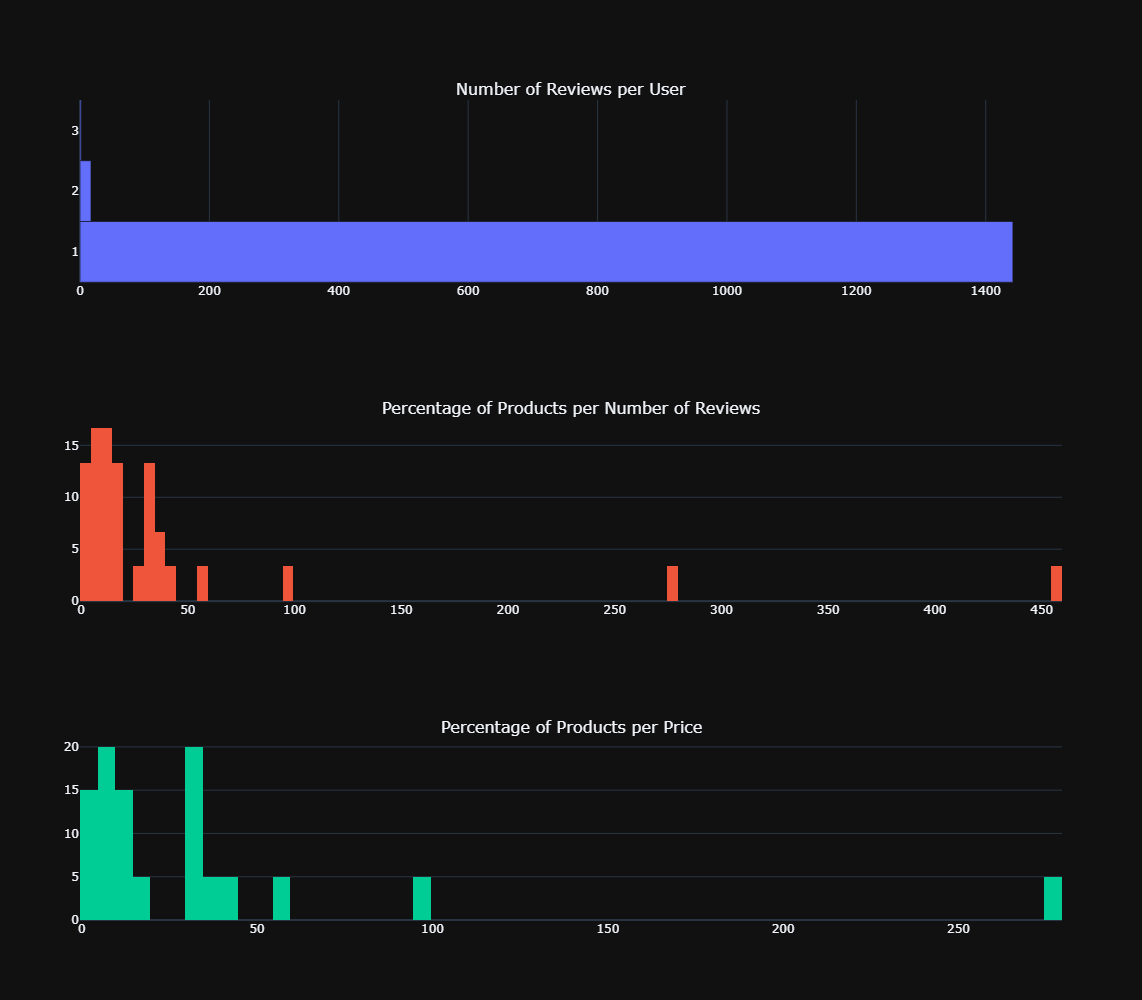

In [64]:
fig1 = make_subplots(rows=3, cols=1, subplot_titles=("Number of Reviews per User", "Percentage of Products per Number of Reviews", \
                                                     "Percentage of Products per Price"))

fig1.add_trace(go.Bar(y=freq, x=n_users, orientation='h', hovertemplate="%{x} users with %{y} reviews"), row=1, col=1)
fig1.add_trace(go.Histogram(x=frequ, y=n_items, histnorm='percent', nbinsx=100, hovertemplate="%{y:0.0f}% of products with %{x} reviews"), row=2, col=1)
fig1.add_trace(go.Histogram(x=pfreq, y=n_price, histnorm='percent', nbinsx=100, hovertemplate="%{y:0.0f}% of products with prices between %{x}"), row=3, col=1)
            
fig1.update_layout(template='plotly_dark', showlegend=False, height=1000)

fig1.show()

In [103]:
df_p = df[['price', 'rating']]

In [105]:
df_p1 = df_p[(df_p != 0).all(1)]   # like in the previous graph, let's exclude null values of price
df_p2 = df_p1[(df_p1 < 100).all(1)]  # given that few products cost more than $100, let's drop them to see the main distribution in more detail

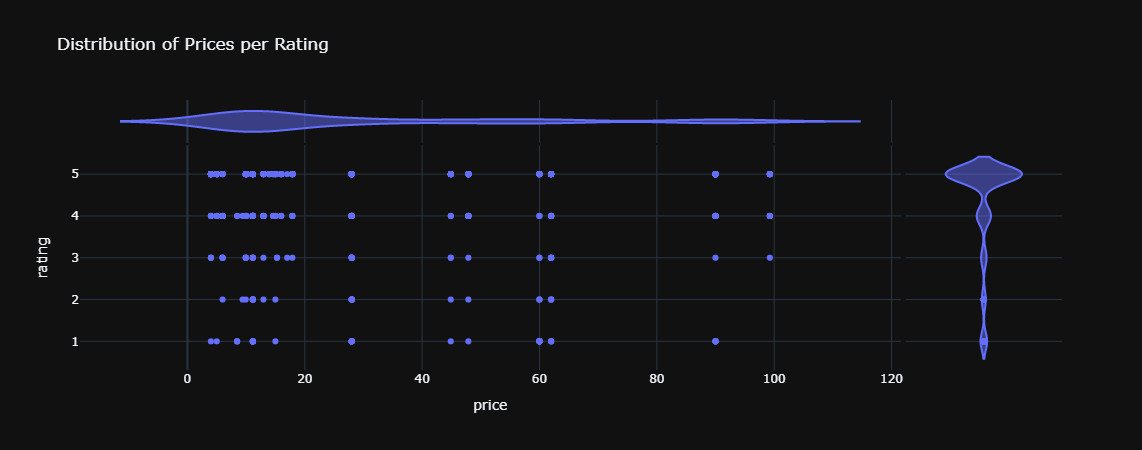

In [106]:
fig2 = px.scatter(df_p2, x=df_p2['price'], y=df_p2['rating'], title='Distribution of Prices per Rating', template='plotly_dark', \
                 marginal_y="violin", marginal_x="violin")

#fig2.update_xaxes(range=[1,100])
fig2.show()

<function matplotlib.pyplot.show(close=None, block=None)>

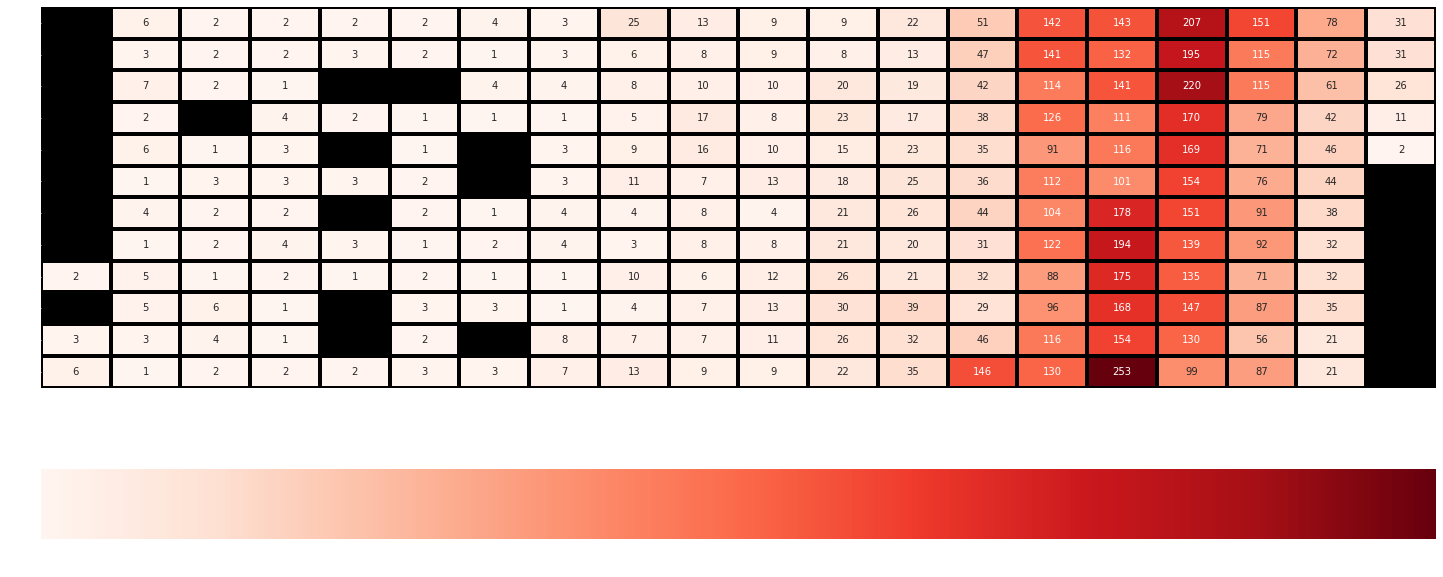

In [107]:
fields = defaultdict(list)

for d in dataset:
    for k, v in d.items():
        fields[k].append(v)
        
temp = fields
temp.pop('reviewerID', None)
temp.pop('reviewText', None)
temp.pop('summary', None)
temp.pop('asin', None)
temp.pop('date', None)

time = pd.DataFrame(temp)
time['count'] = 1
treview = time.drop(['votes', 'rating'], axis=1)
treview = treview.pivot_table('count', 'month', 'year', aggfunc='count')

plt.figure(figsize=(25,10))
plt.style.use("dark_background")

heatMap = sns.heatmap(treview, annot=True, fmt='g', cmap='Reds', linewidths=3, linecolor='black', \
                      cbar_kws={'label': 'Number of reviews per Month', 'orientation': 'horizontal'})
heatMap.set_yticklabels(heatMap.get_yticklabels(), rotation=0)
heatMap.set_xticklabels(heatMap.get_xticklabels(), rotation=0)

plt.show

___

### <div align="center">SENTIMENT ANALYSIS</div>

Now we will perform a **sentiment analysis** of the reviews, to build a **rating predictor model** based on the words used in the text of the reviews.

In [108]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in data:
    r = ''.join([c for c in d['reviewText'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCount[w] += 1
print(len(wordCount))

4820


In [134]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts [:10000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

DATA SPLITTING

In [135]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['reviewText'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in words:
            feat[wordId[w]] += 1
        feat.append(1)
        return feat

In [136]:
random.shuffle(data)

In [137]:
X = [feature(d) for d in data]
y = [d['rating'] for d in data]

In [138]:
N = len(X)
X_train = X[:3*N//5]
X_valid = X[3*N//5:4*N//5]
X_test = X[4*N//5:]
y_train = y[:3*N//5]
y_valid = y[3*N//5:4*N//5]
y_test = y[4*N//5:]

In [139]:
print('Train set = {} \nValidation set = {} \nTest set = {} \nFrom a dataset of {} size.'.format(len(X_train), len(X_valid), len(X_test), len(X)))

Train set = 889 
Validation set = 296 
Test set = 297 
From a dataset of 1482 size.


In [140]:
x1 = X_train
x2 = X_valid
x3 = X_test
y1 = y_train
y2 = y_valid
y3 = y_test

#### LINEAR APPROACH - Linear Regression

In [141]:
theta,residuals,rank,s = np.linalg.lstsq(X, y, rcond=None)

In [142]:
wordWeights = list(zip(theta, words + ['offset']))
wordWeights.sort()

In [143]:
model = linear_model.Ridge(1.0, fit_intercept=False)
model.fit(X_train, y_train)

Ridge(fit_intercept=False)

In [144]:
theta2 = model.coef_

In [145]:
wordsWeight = list(zip(theta2, words + ['offset']))
wordsWeight.sort()

In [146]:
wordWeights[-10:]

[(0.9104589434981305, 'fit'),
 (0.9104589434981311, 'deliv'),
 (0.9104589434981322, 'clearli'),
 (0.9104589434981349, 'enjoy'),
 (0.9104589434981386, 'georgou'),
 (0.9104589434981419, 'inexpens'),
 (0.9104589434981443, 'now'),
 (0.9104589434981561, 'with'),
 (0.910458943498316, 'and'),
 (4.08954105650188, 'offset')]

In [147]:
wordWeights[:10]

[(-3.0895410565019046, 'po'),
 (-3.0895410565019, 'seller'),
 (-3.08954105650189, 'unbox'),
 (-3.089541056501889, 'start'),
 (-3.0895410565018886, 'all'),
 (-3.089541056501888, 'fm'),
 (-3.089541056501887, 'keep'),
 (-3.089541056501886, 'get'),
 (-3.0895410565018855, 'complet'),
 (-3.0895410565018855, 'hi')]

**MODEL EVALUATION**

In [148]:
predictions = model.predict(x1)

In [129]:
differences = [(x-y)**2 for (x,y) in zip(predictions,y1)]

In [149]:
mseTrain = sum(differences) / len(differences)
print('MSE = {}'.format(mseTrain))

MSE = 0.859539549912118


In [150]:
fvuTrain = mseTrain / np.var(y1)
R2_Train = 1-fvuTrain
print('R2 = {}'.format(R2_Train))

R2 = 0.3246695914626413


In [132]:
bestModel = None
bestMSE = None

In [133]:
for lamb in [0.01, 0.1, 1, 10, 100]:
    model = linear_model.Ridge(lamb, fit_intercept=False)
    model.fit(x1, y1)
    
    mseTrain = MSE(model, x1, y1)
    mseValid = MSE(model, x2, y2)
    
    print('lambda = ' + str(lamb) + ' - Training error: ' + str(mseTrain) + ' / Validation error: ' + str(mseValid))
    
    if not bestModel or mseValid < bestMSE:
        bestModel = model
        bestMSE = mseValid
print('\nBest MSE on Validation Set is ' + str(bestMSE) + ' (lambda = ' + str(bestModel.alpha) + ')')

NameError: name 'MSE' is not defined

In [339]:
mseTest = MSE(bestModel, x3, y3)
print('Test error: ' + str(mseTest))

Test error: 1.3591125415989858


In [221]:
fvuTest = mseTest / np.var(y3)
R2_Test = 1-fvuTest
print('R2 Test Set = {}'.format(R2_Test))

R2 Test Set = 0.04689023896596589


___
#### CLASSIFICATION APPROACH - Support Vector Classifier
Will the rating be equal to or greater than 4?

In [340]:
y_class = [(rating >= 4) for rating in y1]

In [343]:
model = svm.SVC()
model.fit(x1, y_class)

SVC()

In [344]:
class_predict = model.predict(x1)

MODEL EVALUATION

In [345]:
correct = class_predict == y_class

In [346]:
accuracy = sum(correct) / len(correct)
print('Accuracy = {}'.format(accuracy))

Accuracy = 0.8638920134983127


In [347]:
TP = sum([(p and l) for (p,l) in zip(class_predict, y_class)])
FP = sum([(p and not l) for (p,l) in zip(class_predict, y_class)])
TN = sum([(not p and not l) for (p,l) in zip(class_predict, y_class)])
FN = sum([(not p and l) for (p,l) in zip(class_predict, y_class)])

In [348]:
print('True Positives: {} \nFalse Positives: {} \nTrue Negatives: {} \nFalse Negatives: {}'\
     .format(TP, FP, TN, FN))

True Positives: 755 
False Positives: 119 
True Negatives: 13 
False Negatives: 2


In [349]:
model_accuracy = (TP+TN)/(TP+TN+FP+FN)
TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
BER = 1 - 1/2 * (TPR + TNR)
precision = TP / (TP+FP)
F1 = 2*(precision*TPR)/(precision+TPR)
print('This model\'s performance is as follows: \nOverall Accuracy: {0:.1%}\nTrue Positive Rate \
(Recall): {0:.1%}\nTrue Negative Rate: {0:.1%}\nBalanced Error Rate: {0:.1%}\nPrecision: {0:.1%}\n\
F1-Score: {0:.1%}'.format(model_accuracy, TPR, TNR, BER, precision, F1))

This model's performance is as follows: 
Overall Accuracy: 86.4%
True Positive Rate (Recall): 86.4%
True Negative Rate: 86.4%
Balanced Error Rate: 86.4%
Precision: 86.4%
F1-Score: 86.4%


In [354]:
model.score(x1,y1,sample_weight=None)

0.04049493813273341

In [242]:
confidences = model.decision_function(x1)

In [243]:
confidenceAndLabels = list(zip(confidences,y_class))

In [249]:
labelsRankedByConfidence = [z[1] for z in confidenceAndLabels]

In [251]:
def precisionAtK(K,y_sorted):
    return sum(y_sorted[:K])/K

In [252]:
def recallAtK(K,y_sorted):
    return sum(y_sorted[:K])/sum(y_sorted)

In [261]:
at = 500
prec = precisionAtK(at, labelsRankedByConfidence)
rec = recallAtK(at, labelsRankedByConfidence)
print('Precision at ' + str(at) + ' is ' + str(prec))
print('Recall at ' + str(at) + ' is ' + str(rec))

Precision at 500 is 0.866
Recall at 500 is 0.571994715984148


In [265]:
confidenceAndLabels[:5]

[(2.041518953867072, True),
 (1.9284113874684847, True),
 (1.5560268834007625, True),
 (3.117024202477381, True),
 (1.8252920537525485, True)]

In [272]:
pr = []
re = []
for K in confidenceAndLabels:
    pr.append(precisionAtK(K, y1))
    re.append(recallAtK(K, y1))

TypeError: slice indices must be integers or None or have an __index__ method

In [274]:

fig5 = px.line(x=len(labelsRankedByConfidence), y=[prec, rec], title='Progression of Confidence (Precision and Recall;)', template='plotly_dark')
#fig2.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig5.show()

ValueError: String or int arguments are only possible when a DataFrame or an array is provided in the `data_frame` argument. No DataFrame was provided, but argument 'x' is of type str or int.

#### MEASUREMENTS

In [275]:
def MSE(model, x1, y1):
    predictions = model.predict(x1)
    differences = [(a-b)**2 for (a,b) in zip(predictions, y1)]
    return sum(differences) / len(differences)

In [276]:
bestModel = None
bestMSE = None

In [309]:
for lamb in [0.01, 0.1, 1, 10, 100]:
    model = linear_model.Ridge(lamb, fit_intercept=False)
    model.fit(x1, y1)
    
    mseTrain = MSE(model, x1, y1)
    mseValid = MSE(model, x2, y2)
    
    print('lambda = ' + str(lamb) + ' - Training error: ' + str(mseTrain) + ' / Validation error: ' + str(mseValid))
    
    if not bestModel or mseValid < bestMSE:
        bestModel = model
        bestMSE = mseValid
print('\nBest MSE on Validation Set is ' + str(bestMSE) + ' (lambda = ' + str(bestModel.alpha) + ')')

lambda = 0.01 - Training error: 0.7629554375441481 / Validation error: 1.1199869701256358
lambda = 0.1 - Training error: 0.7648717834167394 / Validation error: 1.1094121589082948
lambda = 1 - Training error: 0.8241880984297614 / Validation error: 1.076182042436132
lambda = 10 - Training error: 1.0297306928955992 / Validation error: 1.1005382003264015
lambda = 100 - Training error: 1.3400732258418346 / Validation error: 1.3648764485750915

Best MSE on Validation Set is 1.076182042436132 (lambda = 1)


In [279]:
mseTest = MSE(bestModel, x3, y3)
print('Test error: ' + str(mseTest))

Test error: 1.3591125415989858


In [280]:
def cost(theta, labels, lamb):
    unpack(theta)

___
___
### <div align="center">RELATED ITEMS RECOMMENDATION</div>

In [282]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
itemNames = {}

In [283]:
for d in data:
    user, item = d['reviewerID'], d['asin']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    itemNames[item] = d['name']

In [284]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [292]:
def mostRelated(i):
    similarities = []
    users = usersPerItem[i]
    candidateItems = set()
    for u in users:
        candidateItems = candidateItems.union(itemsPerUser[u])
    for i2 in candidateItems:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        similarities.append((sim, i2))
    similarities.sort(reverse=True)
    return similarities[:5]

In [333]:
query = data[1]['asin']

In [334]:
mostRelated(query)

[(0.006622516556291391, '1400501717')]

In [335]:
itemNames[query]

'Barnes & Noble Nook Simple Touch eBook Reader (Wi-Fi Only)'

In [336]:
[itemNames[x[1]] for x in mostRelated(query)]

['Barnes and Noble Nook Simple Touch eBook Reader 2GB WiFi with GlowLight']

___
___
### <div align="center">LATENT FACTOR RECOMMENDATION</div>

In [ ]:
reviewsPerUser = defaultdict(set)
reviewsPerItem = defaultdict(set)

for d in data:
    user,item = d['reviewerID'], d['asin']
    reviewsPerItem[item].add(user)
    itemsPerUser[user].add(item)
    itemNames[item] = d['productName']

In [303]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)

itemNames = {}

for d in data:
    user,item = d['reviewerID'], d['asin']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    itemNames[item] = d['name']

In [332]:
N = len(data)
nUsers = len(itemsPerUser)
nItems = len(usersPerItem)
users = list(itemsPerUser.keys())
items = list(usersPerItem.keys())

print('Users: ' + str(nUsers) + '\nItems: ' + str(nItems))

Users: 1461
Items: 50


In [317]:
*** alpha = np.mean(i['rating'] for i in data)
userBiases = defaultdict(float)
itemBiases = defaultdict(float)
userGamma = {}
itemGamma = {}

TypeError: unsupported operand type(s) for /: 'generator' and 'int'

In [ ]:
N = len(y1)


In [318]:
K = 2

In [319]:
for u in itemsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]

for i in itemsPerItem:
    itemGamma[i] = [random.random() * 0.01 - 0.05 for k in range(K)]

NameError: name 'userGamma' is not defined

In [321]:
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])
def prediction(user,item):
    alpha = userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])
    return alpha

In [322]:
def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

In [323]:
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['reviewerID'], d['asin']) for d in data]
    cost = MSE(predictions, labels)
    print('MSE = ' + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

In [326]:
def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(data)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in itemsPerUser:
        dUserGamma[u] = [0,0 for k in range(K)]
    for i in itemsPerUser:
        dItemGamma[i] = [0,0 for k in range(K)]
    for d in data:
        u,i = d['reviewerID'], d['asin']
        pred = prediction(u,i)
        diff = pred = d('rating')
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return np.array(dtheta)

SyntaxError: invalid syntax (<ipython-input-326-6eb9b00430dd>, line 10)

In [ ]:
MSE(alwaysPredictMean, labels)

In [ ]:
scipy.optimize.fmin_l_bfgs_b(cost, [ratingMean] + [0.0]*(nUsers*(K+1) + nItems*(K+1)),\
                            derivative, args = (labels, 0.001))